# Collecting and wrangling data

The goal is to create a dataframe by merging existing user data with generated data. The data will be used in machine learning classification algorithms to determine which lesson items should be removed.

The dataframe should have:
+ data about 'clone' lesson items (obtained using NLP)
+ accuracy data for problem and theory lesson items
+ duration data for problem and theory lesson items
+ z-score accuracy data for problem and theory lesson items
+ z-score duration data for problem and theory lesson items
+ overall lesson duration data
+ theory/problem indices indicating whether a lesson item is a theory or problem item
+ data from a human expert on which items were selected to be removed 


In [85]:
from docx import *
import re, glob, os
import numpy as np
import scipy as sp
from bs4 import BeautifulSoup
import zipfile
import sklearn
import tempfile
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram
from IPython.display import display, HTML

from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [86]:
%pylab -- inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##1- Running NLP analysis code from python files

In [87]:
%run 'C:/Users/eabalo/Desktop/STAAR35Analyses/src/STAAR_preprocessing_code.py'
%run 'C:/Users/eabalo/Desktop/STAAR35Analyses/src/LSA_code.py'

## 2- Data Munging/Wrangling

In [88]:
#data folder
datafolder = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

In [89]:
#Data collected from users
df_deliv1 = pd.read_csv(datafolder + 'df_deliv1.csv')
df_deliv2 = pd.read_csv(datafolder + 'df_deliv2.csv')
df_lesson = pd.read_csv(datafolder + 'df_lesson.csv')
df_problem = pd.read_csv(datafolder + 'df_problem.csv')
df_labels = pd.read_csv(datafolder + 'df_labels.csv')

In [90]:
#column headers and dataframe dimensions
for i in [df_deliv1, df_deliv2, df_problem, df_lesson, df_labels]:
    print i.columns, '\n', i.shape, '\n'

Index([u'Theory UID', u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'50th percentile duration', u'80th percentile duration', u'ACCURACY',
       u'Accuracy/Duration'],
      dtype='object') 
(907, 8) 

Index([u'Problem UID', u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'Dataset', u'Problem-Dataset Accuracy %', u'IS Accuracy (%)',
       u'Problem input control', u'Most common FR incorrect',
       u'% of most common FR incorrect', u'Most common MC incorrect',
       u'% of most common MC incorrect'],
      dtype='object') 
(3752, 12) 

Index([u'Grade level', u'Problem UID', u'Accuracy',
       u'50th percentile duration', u'80th percentile duration',
       u'Used hints week', u'Used hints AY', u'Additional Problem',
       u'Accuracy/Duration', u'Lesson', u'Supporting/Readiness'],
      dtype='object') 
(769, 11) 

Index([u'Grade Level', u'Lesson', u'#assigned during this week',
       u'#assigned during this AY', u'Accuracy for the week',
       u'Accurac

In [91]:
df_deliv1.describe();

In [92]:
#dropping columns
df_lesson.drop('Accuracy for the week', axis=1, inplace=True)

#renaming columns
df_lesson=df_lesson.rename(columns = {'Grade Level':'Grade level', 'Accuracy for the AY': 'Accuracy',
                                     'Time spent to complete 80% AY': '80th percentile duration',
                                     'Time spent to complete 50% AY': '50th percentile duration'})
df_problem = df_problem.rename(columns={'GRADE': 'Grade level',
                                        'Accuracy avg during AY': 'Accuracy',
                                       'Time spent (50% threshold)': '50th percentile duration',
                                       'Time spent (80% threshold)': '80th percentile duration'})
df_deliv1 = df_deliv1.rename(columns = {'ACCURACY':'Accuracy'})

#choosing non-'additional problem' data in df_problem
df_problem = df_problem[df_problem['Additional Problem'] == 0]

###2-1 Merging theory and problem data sets

In [93]:
#Merging theory and problem data sets
df_thpr = pd.concat([df_deliv1, df_problem])

#reordering and dropping columns
df_thpr = pd.DataFrame(data = df_thpr, columns = ['Lesson', 'Grade level', 'Supporting/Readiness', 'Theory UID', 'Problem UID', 
                   '50th percentile duration', '80th percentile duration','Accuracy', 'Accuracy/Duration'])

In [94]:
print df_thpr.columns
print df_thpr.shape

Index([u'Lesson', u'Grade level', u'Supporting/Readiness', u'Theory UID',
       u'Problem UID', u'50th percentile duration',
       u'80th percentile duration', u'Accuracy', u'Accuracy/Duration'],
      dtype='object')
(1676, 9)


### 2-2 Adding other features

In [95]:
#Theory index
theoryindex = []
for i in df_thpr['Theory UID']:
    #sl = i.split('-')
    if 'th' in str(i):
        theoryindex.append(1)
    else:
        theoryindex.append(0)

#Adding Theory index to df_thpr
df_thpr['Theory?'] = theoryindex

In [96]:
#UID of lesson item
df_thpr['UID'] = df_thpr['Theory UID']
df_thpr['UID'].fillna(df_thpr['Problem UID'], inplace=True)

#dropping columns
df_thpr.drop(['Theory UID', 'Problem UID'], axis=1, inplace=True)

In [97]:
#Z-scores of duration and accuarcy for a given lesson and theory/problem items
#http://pandas.pydata.org/pandas-docs/version/0.13.1/groupby.html
zscore = lambda x: (x - x.mean()) / x.std()

df_thpr['Duration z-score'] = df_thpr.groupby(['Lesson', 'Theory?']).transform(zscore)['80th percentile duration']

df_thpr['Accuracy z-score'] = df_thpr.groupby(['Lesson', 'Theory?']).transform(zscore)['Accuracy']

In [98]:
#Adding overall lesson duration (80th percentile time) to df_thpr

df_temp = pd.DataFrame()
df_temp[['Lesson', 'Lesson duration']] = df_lesson[['Lesson', '80th percentile duration']]

df_thpr = pd.merge(df_thpr, df_temp, on='Lesson')

In [99]:
print df_thpr.columns
print df_thpr.shape

Index([u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'50th percentile duration', u'80th percentile duration', u'Accuracy',
       u'Accuracy/Duration', u'Theory?', u'UID', u'Duration z-score',
       u'Accuracy z-score', u'Lesson duration'],
      dtype='object')
(1676, 12)


#### Exporting df_thpr

In [100]:
#Exporting df_thpr

cleandatapath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

df_thpr.to_csv(cleandatapath + 'df_theoryProblem.csv', index=False)

###2-3 Selecting the 3 longest lessons per grade level per lesson type

In [101]:
#Finding the three longest lessons per grade per lesson type

#initializing empty datframe
df_temp0 = df_thpr[['Lesson', 'Supporting/Readiness', 'Grade level', 'Lesson duration']].copy(deep = True)
df_temp0.drop_duplicates(inplace = True)
df_temp1 = pd.DataFrame(columns = df_temp0.columns)
#df_temp.columns = df_thpr.columns

for lessontype in ['R', 'S']:
    for g in range(3,6):
        #duration
        if lessontype == 'S':
            durationlimit = 2700
            data = df_temp0[(df_temp0['Supporting/Readiness']=='S') & (df_temp0['Lesson duration']>durationlimit) & (df_temp0['Grade level']== g)].sort('Lesson duration', ascending=False).head(3)
        elif lessontype == 'R':
            durationlimit = 3600
            data = df_temp0[(df_temp0['Supporting/Readiness']=='R') & (df_temp0['Lesson duration']>durationlimit) & (df_temp0['Grade level']== g)].sort('Lesson duration', ascending=False).head(3)
        #appeding data to dataframe
        df_temp1 = df_temp1.append(data)

df_temp1;

In [102]:
print df_temp1['Lesson'].unique()

['308A' '305E' '306A' '404H' '404A' '405B' '504H' '503K' '509C' '308B'
 '304G' '307C' '408AB' '404F' '404D' '504D' '507A' '503B']


In [103]:
#Saving data for 3 longest lessons per grade per lesson type in dataframe
df_thpr2 = pd.DataFrame(columns = df_thpr.columns)

#Replacing '408AB' by '406C' because '406C' was analyzed instead of '408AB'
#After tests, the model can be run of 408AB
longlessons = ['308A', '305E', '306A', '404H', '404A', '405B', '504H', '503K', '509C', '308B',
 '304G', '307C', '404F', '404D', '406C', '504D', '507A', '503B']

for lesson in longlessons:
    data = df_thpr[df_thpr['Lesson'] == lesson]
    df_thpr2 = df_thpr2.append(data)

print df_thpr2['Lesson'].unique()

print df_thpr2.shape

df_thpr2.head();

['308A' '305E' '306A' '404H' '404A' '405B' '504H' '503K' '509C' '308B'
 '304G' '307C' '404F' '404D' '406C' '504D' '507A' '503B']
(345, 12)


####Some theory items have 0 accuracy because there are no submits in those lesson items. So the accuracy can be set to 0.

In [104]:
#fill missing data with 0:
df_thpr2.fillna(0, inplace=True);

###2-4 Adding clone index feature to data

Lesson items are labeled with 1 if they are similar to other lesson items in the same lesson or 0 if otherwise. The algorithm applied is Latent Semantic Analysis (LSA). Two or more lesson items are considered 'clones' if the similarity index obtained from LSA and cosine similarity is less than 0.001.

####Sample lesson

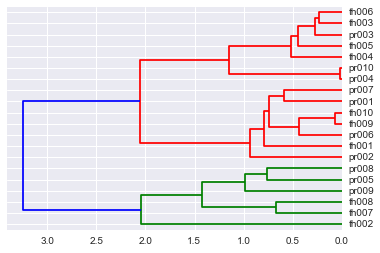

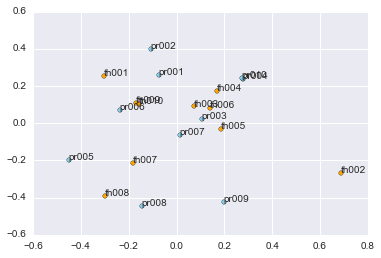

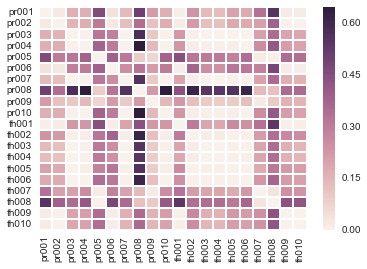

In [140]:
lessonpath = 'C:/Users/eabalo/Documents/STAAR2014/4g/405B/'
lsa_dendrogram(lessonpath)
lsa_mds_plot(lessonpath)
lsa_heatmap(lessonpath)

In [141]:
display(lsa_clone_index(lessonpath).head(7))
print lsa_clone_index(lessonpath).shape

,UID,Clone?
0,TEKS405B-pr001,0
1,TEKS405B-pr002,0
2,TEKS405B-pr003,0
3,TEKS405B-pr004,1
4,TEKS405B-pr005,0
5,TEKS405B-pr006,0
6,TEKS405B-pr007,1


(20, 2)


####Clone indices for longest lessons

In [ ]:
#folder of lessons
staarpath = 'C:/Users/eabalo/Documents/STAAR2014/'

df_clone = pd.DataFrame(columns=['UID', 'Clone?'])

#extracting text from lessons
for lessonname in df_thpr2['Lesson'].unique():
    
    grade = lessonname[0]+'g'
    
    lessonpath = staarpath + grade + '/' + lessonname + '/'
    
    df_clone = df_clone.append(lsa_clone_index(lessonpath))
    
    #lesson number
    #lessonname = lessonpath.split('/')[-2]

In [137]:
display(df_clone.head())
print df_clone.shape

,UID,Clone?
0,TEKS308A-pr001,0
1,TEKS308A-pr002,0
2,TEKS308A-pr003,0
3,TEKS308A-pr004,0
4,TEKS308A-pr005,0


(345, 2)


In [109]:
#Adding the 'Clone' feature to the data
df_thpr2 = pd.merge(df_thpr2, df_clone, on = 'UID')

In [110]:
print df_thpr2.columns

print df_thpr2.shape

Index([u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'50th percentile duration', u'80th percentile duration', u'Accuracy',
       u'Accuracy/Duration', u'Theory?', u'UID', u'Duration z-score',
       u'Accuracy z-score', u'Lesson duration', u'Clone?'],
      dtype='object')
(345, 13)


In [111]:
#Exporting data for 3 longest lessons per grade per lesson type (with Clone indices)

cleandatapath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

df_thpr2.to_csv(cleandatapath + 'df_longLessons.csv', index=False)

###2-5 Extracting classification data (for training data) from analysis document

18 lessons were analyzed by human experts and it was determined which items in the lessons were good candidates for removal. The results of the analysis are saved in a docx file. This information is extracted, processed, and merged with the existing data.

In [112]:
#Extracting classification data
docpath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/manuscript/Strategies_to_shorten_STAAR_lessons_2.docx'

doc = Document(docpath)

In [113]:
lessonnum = []
for table in doc.tables[1:]:
    for paragraph in table.rows[0].cells[1].paragraphs:
        lessonnum.append(paragraph.text)
print lessonnum

[u'3.8A', u'3.5E', u'3.6A', u'3.8B', u'3.4G', u'3.7C', u'4.4H', u'4.4A', u'4.4F', u'4.4D', u'4.5B', u'4.6C', u'5.4H', u'5.3K', u'5.9C', u'5.4D', u'5.7A', u'5.3B']


In [114]:
cloneinfo = []

for table in doc.tables[1:]:
    textinfo = ''
    for paragraph in table.rows[6].cells[1].paragraphs:
        textinfo += paragraph.text + ', '
    cloneinfo.append(textinfo)
print cloneinfo[:2]

[u'th090, th091 (6:57), pr001 (2:18), pr002 (2:17), pr003 (4:06), pr004 (1:11), pr005 (1:26), pr006 (1:45), ', u'pr001 (2:15), th030 (4:15), th050 (5:26), th060 (5:08), pr006* (2:17), ']


In [115]:
df_temp2 = pd.DataFrame(zip(lessonnum, cloneinfo), columns = ['Lesson', 'Cut?'])

In [116]:
display(df_temp2.head())
print df_temp2.shape

,Lesson,Cut?
0,3.8A,"th090, th091 (6:57), pr001 (2:18), pr002 (2:17..."
1,3.5E,"pr001 (2:15), th030 (4:15), th050 (5:26), th06..."
2,3.6A,"th008 (3:14), th010 (1:25), th019 (1:17), th02..."
3,3.8B,"pr001 (1:34), th060 (3:02), pr007 (1:47) (?), ..."
4,3.4G,"pr002 (3:04), pr003 (4:00), th001 (4:27), pr00..."


(18, 2)


In [117]:
#removing durations and other symbols from extracted data
df_temp2['Cut?'] = df_temp2['Cut?'].str.replace(r'\(.+?\)|\*', '')
df_temp2.head()

,Lesson,Cut?
0,3.8A,"th090, th091 , pr001 , pr002 , pr003 , pr004 ,..."
1,3.5E,"pr001 , th030 , th050 , th060 , pr006 ,"
2,3.6A,"th008 , th010 , th019 , th026, th027, th028, t..."
3,3.8B,"pr001 , th060 , pr007 , th130, th133, th137 ,..."
4,3.4G,"pr002 , pr003 , th001 , pr001 , th007 , pr004 ..."


In [118]:
#Correcting the placement of commas
df_temp2['Cut?'] = df_temp2['Cut?'].str.replace(r' ,', ',')
df_temp2.head()

,Lesson,Cut?
0,3.8A,"th090, th091, pr001, pr002, pr003, pr004, pr00..."
1,3.5E,"pr001, th030, th050, th060, pr006,"
2,3.6A,"th008, th010, th019, th026, th027, th028, th029,"
3,3.8B,"pr001, th060, pr007 , th130, th133, th137, th0..."
4,3.4G,"pr002, pr003, th001, pr001, th007, pr004, pr00..."


In [119]:
# function to standardize lesson names
# for example, it changes 3.2A to 302A, and 4.10AB to 410AB
def lessonname(string):
    a, b = string.split('.')
    output = ''
    if re.match(r'(\d{1})([A-Z]{1,3})', b):
        output += a + '0' + b
    elif re.match(r'(\d{2})([A-Z]{1,3})', b):
        output += a + b
    return output

df_temp2['Lesson'] = df_temp2['Lesson'].apply(lessonname)

In [120]:
df_temp2.head()

,Lesson,Cut?
0,308A,"th090, th091, pr001, pr002, pr003, pr004, pr00..."
1,305E,"pr001, th030, th050, th060, pr006,"
2,306A,"th008, th010, th019, th026, th027, th028, th029,"
3,308B,"pr001, th060, pr007 , th130, th133, th137, th0..."
4,304G,"pr002, pr003, th001, pr001, th007, pr004, pr00..."


In [121]:
#Reformatting data to get UID
lessonnum = df_temp2['Lesson']
lessonitems = df_temp2['Cut?']

cutitems = []
for i in range(len(lessonnum)):
    preuid = 'TEKS' + lessonnum[i] + '-'
    postuid = lessonitems[i].split(',')
    itemuid = [preuid + j.strip() for j in postuid]
    cutitems += itemuid
print cutitems[:5]

[u'TEKS308A-th090', u'TEKS308A-th091', u'TEKS308A-pr001', u'TEKS308A-pr002', u'TEKS308A-pr003']


In [122]:
#Creating a dataframe labeling the lesson items selected to be cut
df_cut = pd.DataFrame(columns=['UID', 'Cut?'])
df_cut['UID'] = cutitems
df_cut['Cut?'] = 1

In [123]:
#selecting items with incorrect uid
df_cut[df_cut['UID'].map(len)<14].head()

,UID,Cut?
8,TEKS308A-,1
14,TEKS305E-,1
22,TEKS306A-,1
34,TEKS308B-,1
42,TEKS304G-,1


In [124]:
#removing all rows with incorrect uid
df_cut.drop(df_cut[df_cut['UID'].map(len)<14].index, inplace = True)

#dropping duplicate rows
df_cut.drop_duplicates(inplace = True)

display(df_cut.head())
df_cut.shape

,UID,Cut?
0,TEKS308A-th090,1
1,TEKS308A-th091,1
2,TEKS308A-pr001,1
3,TEKS308A-pr002,1
4,TEKS308A-pr003,1


(132, 2)

###2-7 Merging classification information to 3 longest lessons per grade per type

In [125]:
#data folder
datafolder = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'
#import data
df_thpr2 = pd.read_csv(datafolder + 'df_longLessons.csv')

In [126]:
df_thpr2.columns

Index([u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'50th percentile duration', u'80th percentile duration', u'Accuracy',
       u'Accuracy/Duration', u'Theory?', u'UID', u'Duration z-score',
       u'Accuracy z-score', u'Lesson duration', u'Clone?'],
      dtype='object')

In [127]:
df_thpr2 = pd.merge(df_thpr2, df_cut, how='outer', on = 'UID')

In [128]:
df_thpr2.shape

(345, 14)

In [129]:
#fill missing data in 'Cut?' with 0 (for items that were not selected to be cut)
df_thpr2['Cut?'].fillna(0, inplace=True);

In [130]:
#Exporting data for 3 longest lessons per grade per lesson type (with Clone indices)

cleandatapath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

df_thpr2.to_csv(cleandatapath + 'df_longLessons_final.csv', index=False)